In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [6]:
# Confirmed Deaths
d_df = transform.IRD(min_confirmed=10, min_recovered=0, min_deaths=10)[2]
t_df, h_df, _ = transform.weather()
# Drop low deaths
d_df = d_df[(d_df.max(axis=1)>10)]
t_df = t_df.T[d_df.index.values].T
h_df = h_df.T[d_df.index.values].T

100%|██████████| 264/264 [00:26<00:00,  9.92it/s]


Weather data saved @ /data/COVID-19/covid19/data/weather


In [7]:
# def initial_processing(df):
    
#     for c in ['China', 'Iran', 'Diamond Princess']:
#         df = df[df['Country/Region']!=c]
    
#     df['Country/Region'].iloc[~df['Province/State'].isnull().values] += ' / '+df['Province/State']
#     df = df.drop(columns=['Province/State', 'Lat', 'Long'])
#     df.set_index(keys='Country/Region', inplace=True)
    
#     return df

In [8]:
# # Read in file
# d_df = pd.read_csv('../data/IRD/deaths.csv')
# t_df = pd.read_csv('../data/weather/temperature.csv')
# h_df = pd.read_csv('../data/weather/humidity.csv')
# # Drop China, Iran and Diamond Princess
# d_df = initial_processing(d_df)
# t_df = initial_processing(t_df)
# h_df = initial_processing(h_df)
# # Drop low deaths
# d_df = d_df[(d_df.max(axis=1)>10)]
# t_df = t_df.T[d_df.index.values].T
# h_df = h_df.T[d_df.index.values].T

In [9]:
deaths = {}
temps = {}
hums = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    climate_delay = 28    # days between infection and death
    if start_days[i]<climate_delay:
        climate_delay = start_days[i]
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            time_slice = slice(start_days[i]-climate_delay, end_days[i]-climate_delay)
            deaths[country] = d_df.T[country].values[start_days[i]:end_days[i]]
            temps[country] = np.mean(t_df.T[country].values[time_slice])
            hums[country] = np.mean(h_df.T[country].values[time_slice])
        else:
            deaths[country] = d_df.T[country].values[start_days[i]:]
            temps[country] = np.mean(t_df.T[country].values[start_days[i]-climate_delay:])
            hums[country] = np.mean(h_df.T[country].values[start_days[i]-climate_delay:])

In [10]:
len(deaths)

76

In [11]:
bcg = pd.read_csv('../data/BCG/BCG_ATLAS.csv', index_col='Country')
NONBCG = ['US', 'Italy', 'Netherlands', 'Belgium', 
          'Lebanon']#, 'Indonesia', 'Iran']#, 'Ecuador', 'Andorra', 'Luxembourg']
BCG = ['Brazil', 'Peru', 'India', 'Romania', 'Turkey', 
       'Bulgaria', 'Mexico', 'Bosnia and Herzegovina', 'Croatia', 'Slovenia', 'Finland', 
       'United Kingdom', 'Poland', 'Ireland', 'France', 
       'Austria']#, 'Denmark', ], 'Germany', 'Jordan', 'Kazakhstan']
nonbcg = bcg.T[NONBCG].T
bcg = bcg.T[BCG].T

In [12]:
bcg_countries = list(bcg.index.intersection(deaths.keys()))
nonbcg_countries = list(nonbcg.index.intersection(deaths.keys()))
# bcg_countries = list(bcg[bcg['WBIG']<3].index.intersection(deaths.keys()))

In [13]:
len(bcg_countries), len(nonbcg_countries)

(16, 5)

In [14]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

# Bayesian Model

In [15]:
def model():
    
    N_bcg = len(bcg_countries)
    N_nbcg = len(nonbcg_countries)
    N = N_nbcg + N_bcg
    
    Di_bcg = normalHP('Di_bcg', 7.0, 3.0, N_bcg)
    GR_bcg = normalHP('GR_bcg', 1.3, 0.5, N_bcg)
    
    Di_nbcg = normalHP('Di_nbcg', 7.0, 3.0, N_nbcg)
    GR_nbcg = normalHP('GR_nbcg', 1.3, 0.5, N_nbcg)   
    
    alpha = numpyro.sample('alpha', dist.Normal(0.0, 0.1))
    beta = numpyro.sample('beta', dist.Normal(0.0, 0.1))
    
#     alpha = normalHP('alpha', 0.0, 0.1, N)
#     beta = normalHP('beta', 0.0, 0.1, N)
        
    # Create likelihood for each country    
    
    for i, country in enumerate(bcg_countries):
        dead = deaths[country]
        t = np.arange(len(dead))
        prediction = Di_bcg[i]*(GR_bcg[i]+alpha*temps[country]+beta*hums[country])**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)
        
    for i, country in enumerate(nonbcg_countries):
        dead = deaths[country]
        t = np.arange(len(dead))        
        prediction = Di_nbcg[i]*(GR_nbcg[i]+alpha*temps[country]+beta*hums[country])**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [16]:
N_bcg = len(bcg_countries)
N_nbcg = len(nonbcg_countries)
N = N_nbcg + N_bcg

init_params = {'Di_bcg_grp_mean': 7.0*np.ones((N_chains, 1)),
               'GR_bcg_grp_mean': 1.3*np.ones((N_chains, 1)),
               'Di_bcg_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'GR_bcg_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Di_bcg_ind': 7.0*np.ones((N_chains, N_bcg)),
               'GR_bcg_ind': 1.3*np.ones((N_chains, N_bcg)),
               'Di_nbcg_grp_mean': 0.1*np.ones((N_chains, 1)),
               'GR_nbcg_grp_mean': 1.3*np.ones((N_chains, 1)),
               'Di_nbcg_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'GR_nbcg_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Di_nbcg_ind': 7.0*np.ones((N_chains, N_nbcg)),
               'GR_nbcg_ind': 1.3*np.ones((N_chains, N_nbcg)),
               'alpha': 0.0*np.ones((N_chains, 1)),
               'beta': 0.0*np.ones((N_chains, 1)),
#                'alpha_grp_sigma': 0.1*np.ones((N_chains, 1)),
#                'beta_grp_sigma': 0.1*np.ones((N_chains, 1)),
#                'alpha_ind': 0.0*np.ones((N_chains, N)),
#                'beta_ind': 0.0*np.ones((N_chains, N)),
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=5000, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [17]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 8839.182713508606 s


In [18]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.3.2_BHM_BCG_Climate_EXP_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  Di_bcg_grp_mean[0]      9.14      1.31      9.15      6.95     11.24    128.18      1.01
 Di_bcg_grp_sigma[0]      6.33      0.97      6.23      4.82      7.92   6582.24      1.00
       Di_bcg_ind[0]     19.44      0.95     19.42     17.93     21.02  30594.75      1.00
       Di_bcg_ind[1]      5.10      0.59      5.05      4.24      6.17    263.90      1.00
       Di_bcg_ind[2]      4.58      0.47      4.55      3.81      5.34    321.29      1.00
       Di_bcg_ind[3]     18.87      1.24     18.85     16.80     20.87   3551.95      1.00
       Di_bcg_ind[4]     26.17      1.20     26.15     24.18     28.11  36089.90      1.00
       Di_bcg_ind[5]      6.93      1.09      6.87      5.16      8.77    103.45      1.02
       Di_bcg_ind[6]      5.59      0.62      5.54      4.62      6.63    446.30      1.01
       Di_bcg_ind[7]      6.44      0.92      6.41      4.96      7.93    332.56      1.0

In [19]:
samples = {}
with h5py.File('../data/nb_samples/4.3.2_BHM_BCG_Climate_EXP_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

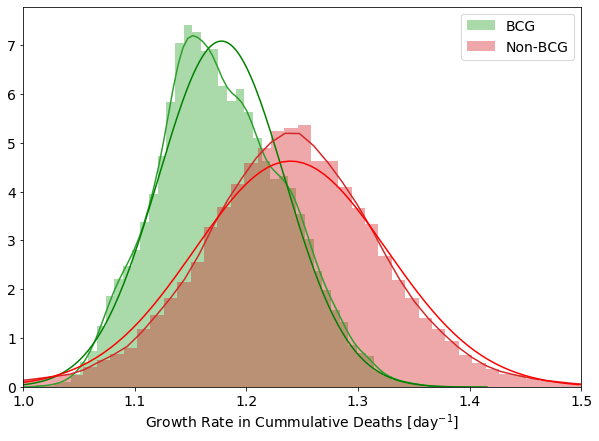

In [20]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['GR_bcg_grp_mean'], bins=50, fit=norm, 
             fit_kws={'color':'green'}, color='tab:green', label='BCG')
sns.distplot(samples['GR_nbcg_grp_mean'], bins=100, fit=norm, 
             fit_kws={'color':'red'}, color='tab:red', label='Non-BCG')
plt.xlabel(r'Growth Rate in Cummulative Deaths [day$^{-1}$]')
plt.xlim(1.0, 1.5)
plt.legend()
plt.savefig('../plots/4.3.2_Growth_Rate_BCG_Parents.png', dpi=200)

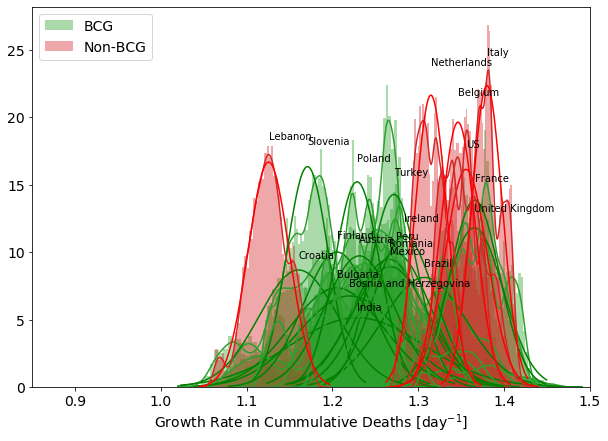

In [28]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(bcg_countries):
    mn = np.mean(samples['GR_bcg_ind'][:,i])
    std = np.std(samples['GR_bcg_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['GR_bcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green', label='BCG')
    else:
        sns.distplot(samples['GR_bcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green')
for i, c in enumerate(nonbcg_countries):
    mn = np.mean(samples['GR_nbcg_ind'][:,i])
    std = np.std(samples['GR_nbcg_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['GR_nbcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red', label='Non-BCG')
    else:
        sns.distplot(samples['GR_nbcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red')
    
plt.legend()
plt.xlim(0.85, 1.5)
plt.xlabel(r'Growth Rate in Cummulative Deaths [day$^{-1}$]')
plt.savefig('../plots/4.3_Growth_Rate_BCG_Countries.png', dpi=200)

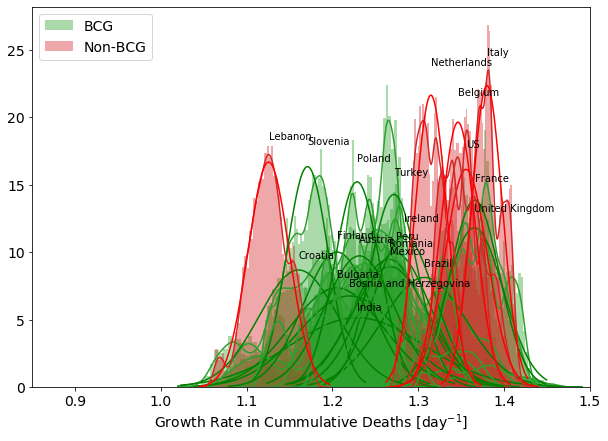

In [29]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(bcg_countries):
    mn = np.mean(samples['GR_bcg_ind'][:,i])
    std = np.std(samples['GR_bcg_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['GR_bcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green', label='BCG')
    else:
        sns.distplot(samples['GR_bcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green')
for i, c in enumerate(nonbcg_countries):
    mn = np.mean(samples['GR_nbcg_ind'][:,i])
    std = np.std(samples['GR_nbcg_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['GR_nbcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red', label='Non-BCG')
    else:
        sns.distplot(samples['GR_nbcg_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red')
    
plt.legend()
plt.xlim(0.85, 1.5)
plt.xlabel(r'Growth Rate in Cummulative Deaths [day$^{-1}$]')
plt.savefig('../plots/4.3_Growth_Rate_BCG_Countries.png', dpi=200)

# Temperature Coefficient

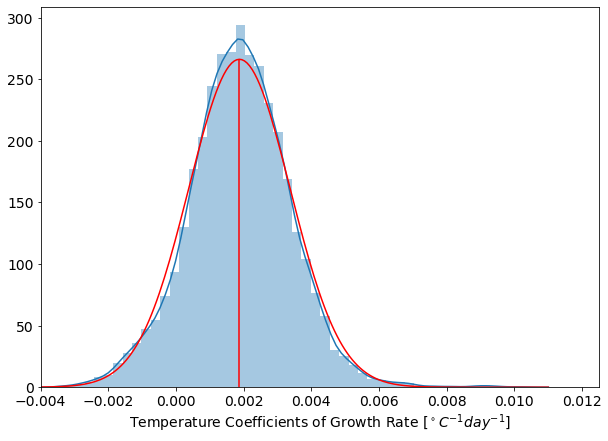

In [22]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'red'}, color='tab:blue')
plt.xlabel(r'Temperature Coefficients of Growth Rate [$^\circ C^{-1} day^{-1}$]')
plt.vlines(np.mean(samples['alpha']), 0, norm.pdf(np.mean(samples['alpha']), 
                                                           *norm.fit(samples['alpha'])), 'r')
plt.xlim(-0.004, 0.0125)
plt.savefig('../plots/4.3_Temperature_Coeffecient_Parent.png', dpi=200)

In [ ]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(bcg_countries):
    mn = np.mean(samples['alpha_ind'][:,i])
    std = np.std(samples['alpha_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['alpha_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green', label='BCG')
    else:
        sns.distplot(samples['alpha_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green')#, label='Non-BCG')
for i, c in enumerate(nonbcg_countries):
    mn = np.mean(samples['alpha_ind'][:,N_bcg+i])
    std = np.std(samples['alpha_ind'][:,N_bcg+i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['alpha_ind'][:,N_bcg+i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red', label='Non-BCG')
    else:
        sns.distplot(samples['alpha_ind'][:,N_bcg+i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red')#, label='Non-BCG')
    
plt.legend()
plt.xlim(-0.02,0.025)
plt.xlabel(r'Temperature Coefficients of Growth Rate [$^\circ C^{-1} day^{-1}$]')
plt.savefig('../plots/4.3_Temperature_Coeffecients_Countries.png', dpi=200)

# Humidity Coefficient

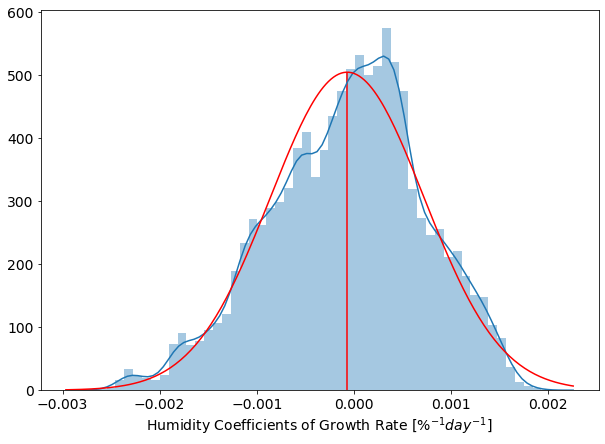

In [24]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['beta'], bins=50, fit=norm, 
             fit_kws={'color':'red'}, color='tab:blue')
plt.vlines(np.mean(samples['beta']), 0, norm.pdf(np.mean(samples['beta']), 
                                                           *norm.fit(samples['beta'])), 'r')
plt.xlabel(r'Humidity Coefficients of Growth Rate [$\%^{-1} day^{-1}$]')
# plt.xlim(-0.25, 0.25)
plt.savefig('../plots/4.3_Humidity_Coeffecient_Parent.png', dpi=200)

In [ ]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(bcg_countries):
    mn = np.mean(samples['beta_ind'][:,i])
    std = np.std(samples['beta_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['beta_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green', label='BCG')
    else:
        sns.distplot(samples['beta_ind'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green')#, label='Non-BCG')
for i, c in enumerate(nonbcg_countries):
    mn = np.mean(samples['beta_ind'][:,N_bcg+i])
    std = np.std(samples['beta_ind'][:,N_bcg+i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['beta_ind'][:,N_bcg+i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red', label='Non-BCG')
    else:
        sns.distplot(samples['beta_ind'][:,N_bcg+i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red')#, label='Non-BCG')
    
plt.legend()
plt.xlabel(r'Humidity Coefficients of Growth Rate [$\%^{-1} day^{-1}$]')
plt.savefig('../plots/4.3_Humidity_Coefficients_Countries.png', dpi=200)

# Example Plots

In [ ]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(5, 5, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(bcg_countries):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy(np.mean(samples['Di_bcg_ind'][:,i])*np.mean(samples['GR_bcg_ind'][:,i])**t, 'r')
    a[i].semilogy((samples['Di_bcg_ind'][::10,i:i+1]*samples['GR_bcg_ind'][::10,i:i+1]**t[None,:]).T, 'r', alpha=0.01)

for i, c in enumerate(nonbcg_countries):
    t = np.arange(len(deaths[c]))
    a[N_bcg+i].set_title(c)
    a[N_bcg+i].semilogy(deaths[c], 'o')
    a[N_bcg+i].semilogy(np.mean(samples['Di_nbcg_ind'][:,i])*np.mean(samples['GR_nbcg_ind'][:,i])**t, 'r')
    a[N_bcg+i].semilogy((samples['Di_nbcg_ind'][::10,i:i+1]*samples['GR_nbcg_ind'][::10,i:i+1]**t[None,:]).T, 'r', alpha=0.01)
    
plt.savefig('../plots/4.3_ExampleFits.png', dpi=200) 
plt.rcParams['font.size'] = 14

# Trace Plots

Text(0, 0.5, 'Growth Rate')

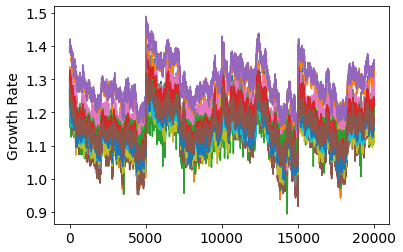

In [25]:
plt.plot(samples['GR_bcg_ind'])
plt.ylabel('Growth Rate')

Text(0, 0.5, 'Initial Deaths')

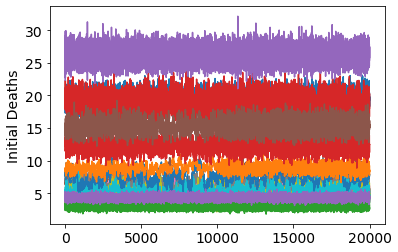

In [26]:
plt.plot(samples['Di_bcg_ind'])
plt.ylabel('Initial Deaths')